In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

## filtration function

In [2]:
def merge_column_name(column):
    return "_".join(column)

def filter_iedb_dataset(iedb_df, include_qualitative=True, include_mass_spec=True):
    QUALITATIVE_TO_AFFINITY_AND_INEQUALITY = {
    "Negative": (5000.0, ">"),
    "Positive": (500.0, "<"),  # used for mass-spec hits
    "Positive-High": (100.0, "<"),
    "Positive-Intermediate": (1000.0, "<"),
    "Positive-Low": (5000.0, "<"),
    }
    QUALITATIVE_TO_AFFINITY = dict(
        (key, value[0]) for (key, value)
        in QUALITATIVE_TO_AFFINITY_AND_INEQUALITY.items())
    QUALITATIVE_TO_INEQUALITY = dict(
        (key, value[1]) for (key, value)
        in QUALITATIVE_TO_AFFINITY_AND_INEQUALITY.items())
    
    
    
    print("Loaded iedb data: %s" % str(iedb_df.shape))
    filtered_df = iedb_df.copy()
    filtered_df = filtered_df[filtered_df[('Epitope', 'Object Type')] == "Linear peptide"]

    print("Linear peptides only, remaining: %d" % len(filtered_df))
    
    ## Clear bad data
    print("Subselecting to valid peptides (dropping peptides with PTMs). Starting with: %d" % len(filtered_df))
    filtered_df[('Epitope', 'Name')] = filtered_df[('Epitope', 'Name')].str.strip()
    filtered_df = filtered_df.loc[
        iedb_df[('Epitope', 'Name')].str.match("^[ACDEFGHIKLMNPQRSTVWY]+$")
    ]
    filtered_df = filtered_df.reset_index(drop=True)
    print("Now: %d" % len(filtered_df))
    
    
#     filtered_df = filtered_df[~filtered_df[('Epitope', 'Description')].str.contains("\+")]
#     filtered_df = filtered_df[~filtered_df[('Epitope', 'Description')].str.contains("X")]
#     filtered_df = filtered_df[~filtered_df[('Epitope', 'Description')].str.contains("B")]
#     filtered_df = filtered_df[~filtered_df[('Epitope', 'Description')].str.contains("Z")]
    filtered_df = filtered_df[[
    ('Epitope', 'Object Type'),
    ('Epitope', 'Name'),
    ('Epitope', 'Species'),
    ('Assay', 'Units'),
    ('Assay', 'Qualitative Measurement'),
    ('Assay', 'Quantitative measurement'),
     ('Assay', 'Measurement Inequality'),
    ('MHC Restriction', 'Name'),
    ('MHC Restriction', 'IRI'),
    ('MHC Restriction', 'Class'),
    ('Assay', 'Response measured'),
    ('Assay', 'Method'),
    ('Epitope', 'Molecule Parent IRI'),
    ('Epitope', 'Starting Position'),
    ('Epitope', 'Ending Position')
             ]]
    print("Subselecting assay groups as in Sarkizova. Starting with: %d" % len(filtered_df))

    assay_type1 = (filtered_df[('Assay', 'Response measured')] == 'half maximal effective concentration (EC50)') & \
                                              (filtered_df[('Assay', 'Method')] == 'purified MHC/direct/fluorescence')
    filtered_df = filtered_df[~assay_type1]
    assay_type2 = (filtered_df[('Assay', 'Response measured')] =='dissociation constant KD') & \
                                                  (filtered_df[('Assay', 'Method')] == 'purified MHC/direct/radioactivity')
    filtered_df = filtered_df[~assay_type2]
    assay_type3 = (filtered_df[('Assay', 'Response measured')] == 'half maximal effective concentration (EC50)') & \
                                                  (filtered_df[('Assay', 'Method')] == 'cellular MHC/direct/fluorescence')
    filtered_df = filtered_df[~assay_type3]
    filtered_df.columns = filtered_df.columns.map(merge_column_name)
    filtered_df = filtered_df.reset_index(drop=True)
    print("Now: %d" % len(filtered_df))


    quantitative = filtered_df.loc[filtered_df["Assay_Units"] == "nM"].copy()
    quantitative["measurement_type"] = "quantitative"
    quantitative = quantitative.rename(columns={"Assay_Measurement Inequality":"measurement_inequality"})
    quantitative['measurement_inequality'] = quantitative['measurement_inequality'].fillna("=").map(lambda s: {">=": ">", "<=": "<"}.get(s, s))
    print("Quantitative measurements: %d" % len(quantitative))
    # Ilya: remove quantitative measurement with no measurement values
    print("Dropping quantitative measurements with no measurement value")
    quantitative.dropna(subset = ["Assay_Quantitative measurement"], inplace=True)
    print("Quantitative measurements: %d" % len(quantitative))
    
    qualitative = filtered_df.loc[filtered_df["Assay_Units"] != "nM"].copy()
    qualitative["measurement_type"] = "qualitative"
    print("Qualitative measurements: %d" % len(qualitative))
    if not include_mass_spec:
        qualitative = qualitative.loc[
            (~qualitative["Assay_Method"].str.contains("mass spec"))
        ].copy()

    qualitative["Assay_Quantitative measurement"] = (
        qualitative["Assay_Qualitative Measurement"].map(QUALITATIVE_TO_AFFINITY))
    qualitative = qualitative.drop(columns=['Assay_Measurement Inequality'])
    qualitative["measurement_inequality"] = (qualitative["Assay_Qualitative Measurement"].map(QUALITATIVE_TO_INEQUALITY))
    print("Qualitative measurements (possibly after dropping MS): %d" % (
        len(qualitative)))
    
    filtered_df = pd.concat(
        (
            ([quantitative]) +
            ([qualitative] if include_qualitative else [])),
        ignore_index=True)
    print("Now: %d" % len(filtered_df))
    
    ## Mark binders
    binder_list = ['Positive', 'Positive-High', 'Positive-Intermediate', 'Positive-Low']
    non_binder_list = ['Negative']
    filtered_df.loc[filtered_df['Assay_Quantitative measurement'] <= 500, 'binder'] = 1
    filtered_df.loc[filtered_df['Assay_Quantitative measurement'] > 500, 'binder'] = 0
    #
    # filtered_df.loc[filtered_df['Qualitative Measure'].isin(binder_list),'binder'] = 1
    # filtered_df.loc[filtered_df['Qualitative Measure'].isin(non_binder_list),'binder'] = 0
    
    filtered_df.binder = filtered_df.binder.astype(int)
    filtered_df = filtered_df.drop(columns=[
     # 'Qualitative Measure',
     'Assay_Units',
     'Epitope_Object Type',
     'MHC Restriction_IRI'
     ])
    
    filtered_df = filtered_df.rename(columns={"MHC Restriction_Name":"allele", 
                                              "Epitope_Name":"peptide",
                                              "Assay_Quantitative measurement":"measurement_value",
                                              'Assay_Qualitative Measurement': "qualitative_measurement",
                                              "Epitope_Molecule Parent IRI":"protein_id",
                                              "Epitope_Starting Position":"peptide_start",
                                              "Epitope_Ending Position": "peptide_end"})
    filtered_df['length'] = filtered_df['peptide'].str.len()
    
    #filtered_df['allele'] = filtered_df['original_allele'].map(parse).to_string()
    
    print("Take unique (peptide, allele, length, 'measurement_value', 'measurement_inequality','qualitative_measurement' 'measurement_type', binder). Starting with: %d" % len(filtered_df))

    filtered_df = filtered_df.drop_duplicates([
    'peptide',
    'allele',
    'length',
    'measurement_value',
    'measurement_inequality',
    'measurement_type',
    'qualitative_measurement',
    'binder',
    'protein_id',
    'peptide_start',
    'peptide_end']).reset_index(drop=True)
    print("Now: %d" % len(filtered_df))

    
    print("Allele_distribution")
    print(filtered_df['allele'].value_counts()[:30])
    


    assert 'peptide' in filtered_df.columns
    assert 'allele' in filtered_df.columns
    assert 'length' in filtered_df.columns
    assert 'binder' in filtered_df.columns
    return filtered_df

## open data

In [3]:
data_path_full = "C:/Projects/grandmaster/notebooks/mhc_ligand_full.csv"

Read only those columns

In [4]:
headers = pd.read_csv(data_path_full, sep=',', header=None, nrows=2)
mi = pd.MultiIndex.from_frame(headers.T)


usecols=[
    ('Epitope', 'Object Type'),
    ('Epitope', 'Name'),
    ('Epitope', 'Species'),
    ('Assay', 'Units'),
    ('Assay', 'Qualitative Measurement'),
    ('Assay', 'Quantitative measurement'),
     ('Assay', 'Measurement Inequality'),
    ('MHC Restriction', 'Name'),
    ('MHC Restriction', 'IRI'),
    ('MHC Restriction', 'Class'),
    ('Assay', 'Response measured'),
    ('Assay', 'Method'),
    ('Epitope', 'Molecule Parent IRI'),
    ('Epitope', 'Starting Position'),
    ('Epitope', 'Ending Position')
             ]

desired_index_values = [item for item in mi if item in usecols]
desired_index_indexes = [col_index  for col_index, col in enumerate(mi) if col in usecols]
dat_names = list(map(lambda x: f"{x[0]}_{x[1]}", desired_index_values ))

In [5]:
chunks=pd.read_table(data_path_full,chunksize=400000,sep=',',usecols=desired_index_indexes,
       names=desired_index_values,skiprows=2,header=None,)

df=pd.DataFrame()
%time df=pd.concat(chunk for chunk in chunks)

<timed exec>:1: DtypeWarning: Columns (92,95) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:1: DtypeWarning: Columns (92,95) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:1: DtypeWarning: Columns (92,95) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:1: DtypeWarning: Columns (92,95) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:1: DtypeWarning: Columns (92,95) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:1: DtypeWarning: Columns (92,95) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:1: DtypeWarning: Columns (92,95) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:1: DtypeWarning: Columns (22,25,92,95) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:1: DtypeWarning: Colu

CPU times: total: 47.2 s
Wall time: 1min 17s


In [8]:
df[df[('MHC Restriction', 'Class')] == 'II'][('Assay', 'Quantitative measurement')]

71         4600.0
72         7100.0
73         5100.0
74         2000.0
75         6100.0
            ...  
4881476       NaN
4881477       NaN
4881478       NaN
4881479       NaN
4881480       NaN
Name: (Assay, Quantitative measurement), Length: 1807876, dtype: float64

In [7]:
#filtatration
df = filter_iedb_dataset(df)

Loaded iedb data: (4881627, 15)
Linear peptides only, remaining: 4880866
Subselecting to valid peptides (dropping peptides with PTMs). Starting with: 4880866
Now: 4650805
Subselecting assay groups as in Sarkizova. Starting with: 4650805
Now: 4649049
Quantitative measurements: 241068
Dropping quantitative measurements with no measurement value
Quantitative measurements: 240883
Qualitative measurements: 4407981
Qualitative measurements (possibly after dropping MS): 4407981
Now: 4648864
Take unique (peptide, allele, length, 'measurement_value', 'measurement_inequality','qualitative_measurement' 'measurement_type', binder). Starting with: 4648864
Now: 2749874
Allele_distribution
HLA class I                  458004
HLA class II                 248634
HLA-DR                       101795
HLA-B*27:05                   93630
HLA-DRB1*15:01                89779
HLA-A*02:01                   83037
HLA-DRB1*03:01                79107
HLA-DRB1*13:02                73060
HLA-DRB1*13:01              

In [8]:
ALLELES = [
    # 'H2-IAb',
    # 'H2-IAd',
    # 'H2-IAk',
    # 'H2-IAq',
    # 'H2-IAs',
    # 'H2-IAu',
    # 'H2-IEd',
    # 'H2-IAk',
    # 'H2-Kb',
    # 'H2-Db',
    #'HLA-A*02:01',
    #'HLA-A*03:01',
    #'HLA-A*01:01',
    #'HLA-A*24:02',
    #'HLA-B*27:05',
    #'HLA-B*07:02',
    #'HLA-B*57:01',
    #'HLA-B*15:02',
    #'HLA-C*12:02',
    #'HLA-A*24:02',
    #'HLA-A*11:01',
    'HLA-DRB1*03:01',
    'HLA-DRB3*01:01',
    'HLA-DRB1*10:01',
    'HLA-DRB1*07:01',
    'HLA-DRB1*11:01',
    'HLA-DRB1*12:01',
    'HLA-DRB1*13:03',
    'HLA-DRB1*15:01',
    'HLA-DRB4*01:01',
    'HLA-DRB3*02:02',
    #'HLA-DRB5*01:01'
    #'HLA-DRB1*04:01',
    #'HLA-DRB1*15:01',
    #'HLA-DRB3*01:01',
    #'HLA-DRB5*01:01',
    #'HLA-DPA1*01:03/DPB1*04:01',
    #'HLA-DPA1*02:02/DPB1*05:01'
]

target_df = df[df.allele.isin(ALLELES)]
target_df.binder.value_counts(dropna=False)


0    172173
1     50737
Name: binder, dtype: int64

In [9]:
def make_per_allele_df(source_df, ALLELES):
    per_allele_df = dict()
    for allele_name in ALLELES:
        allele_df = source_df[source_df['allele'] == allele_name] 
        print(f"------Allele {allele_name} ----------")
        print("Binders_distribution:")
        print(allele_df['binder'].value_counts())
        print("Length_distribution:")
        print(allele_df['length'].value_counts().iloc[:10])
        per_allele_df[allele_name] = allele_df
    return per_allele_df
        
        
per_allele_df = make_per_allele_df(target_df, ALLELES)

------Allele HLA-DRB1*03:01 ----------
Binders_distribution:
0    71929
1     7178
Name: binder, dtype: int64
Length_distribution:
13    70246
15     3628
20     1043
16     1017
17      815
14      710
18      592
19      374
12      220
21      183
Name: length, dtype: int64
------Allele HLA-DRB3*01:01 ----------
Binders_distribution:
1    3144
0    2019
Name: binder, dtype: int64
Length_distribution:
15    2489
16     488
14     444
13     379
17     376
18     264
12     217
19     157
20     137
21      62
Name: length, dtype: int64
------Allele HLA-DRB1*10:01 ----------
Binders_distribution:
1    3552
0     195
Name: binder, dtype: int64
Length_distribution:
15    1133
16     720
14     532
17     493
18     257
13     249
19     141
20     107
12      47
21      24
Name: length, dtype: int64
------Allele HLA-DRB1*07:01 ----------
Binders_distribution:
0    11115
1     8730
Name: binder, dtype: int64
Length_distribution:
15    13923
16     1273
14      882
20      860
17      831

In [12]:
ALLELES = [
    # 'H2-IAb',
    # 'H2-IAd',
    # 'H2-IAk',
    # 'H2-IAq',
    # 'H2-IAs',
    # 'H2-IAu',
    # 'H2-IEd',
    # 'H2-IAk',
     'H2-Kb',
     'H2-Db',
    'HLA-A*02:01',
    'HLA-A*03:01',
    'HLA-A*01:01',
    'HLA-A*24:02',
    'HLA-B*27:05',
    'HLA-B*07:02',
    'HLA-B*57:01',
    'HLA-B*15:02',
    'HLA-C*12:02',
    #'HLA-A*24:02',
    #'HLA-A*11:01',
    'HLA-DRB1*01:01',
    'HLA-DRB1*04:01',
    'HLA-DRB1*07:01',
    'HLA-DRB1*04:04',
    #'HLA-DRB1*04:01',
    #'HLA-DRB1*15:01',
    #'HLA-DRB3*01:01',
    'HLA-DRB5*01:01',
    'HLA-DPA1*01:03/DPB1*04:01',
    'HLA-DPA1*02:02/DPB1*05:01'
]

target_df = df[df.allele.isin(ALLELES)]
target_df.binder.value_counts(dropna=False)


1    399917
0     97353
Name: binder, dtype: int64

In [10]:
def make_per_allele_df(source_df, ALLELES):
    per_allele_df = dict()
    for allele_name in ALLELES:
        # Filter the dataframe for the current allele
        allele_df = source_df[source_df['allele'] == allele_name].copy()  # Use `.copy()` to avoid SettingWithCopyWarning
        
        print(f"------Allele {allele_name} ----------")
        print("Binders_distribution:")
        print(allele_df['binder'].value_counts())
        
        # Calculate peptide lengths
        allele_df['length'] = allele_df['peptide'].str.len()
        
        print("Length_distribution:")
        print(allele_df['length'].value_counts().iloc[:10])
        
        # Add to dictionary
        per_allele_df[allele_name] = allele_df

    return per_allele_df

# Usage
per_allele_df = make_per_allele_df(df, ALLELES)


------Allele HLA-DRB1*03:01 ----------
Binders_distribution:
0    71929
1     7178
Name: binder, dtype: int64
Length_distribution:
13    70246
15     3628
20     1043
16     1017
17      815
14      710
18      592
19      374
12      220
21      183
Name: length, dtype: int64
------Allele HLA-DRB3*01:01 ----------
Binders_distribution:
1    3144
0    2019
Name: binder, dtype: int64
Length_distribution:
15    2489
16     488
14     444
13     379
17     376
18     264
12     217
19     157
20     137
21      62
Name: length, dtype: int64
------Allele HLA-DRB1*10:01 ----------
Binders_distribution:
1    3552
0     195
Name: binder, dtype: int64
Length_distribution:
15    1133
16     720
14     532
17     493
18     257
13     249
19     141
20     107
12      47
21      24
Name: length, dtype: int64
------Allele HLA-DRB1*07:01 ----------
Binders_distribution:
0    11115
1     8730
Name: binder, dtype: int64
Length_distribution:
15    13923
16     1273
14      882
20      860
17      831

In [17]:
per_allele_df["HLA-DRB1*03:01"]["binder"]

97         1
119        1
140        1
186        1
228        1
          ..
2749092    0
2749098    0
2749104    0
2749110    0
2749116    1
Name: binder, Length: 79107, dtype: int32

In [16]:
per_allele_df['HLA-DRB1*11:01']

,peptide,Epitope_Species,qualitative_measurement,measurement_value,measurement_inequality,allele,MHC Restriction_Class,Assay_Response measured,Assay_Method,protein_id,peptide_start,peptide_end,measurement_type,binder,length
101,VGPLTVNEKRRLKLI,Hepatitis B virus,Positive-Low,6666.0,=,HLA-DRB1*11:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q69028,96.0,110.0,quantitative,0,15
112,RHYLHTLWKAGILYK,Hepatitis B virus,Positive-High,42.0,=,HLA-DRB1*11:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q69028,145.0,159.0,quantitative,1,15
132,LQSLTNLLSSNLSWL,Hepatitis B virus,Positive-Intermediate,303.0,=,HLA-DRB1*11:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q69028,412.0,426.0,quantitative,1,15
146,SSNLSWLSLDVSAAF,Hepatitis B virus,Positive-Low,4923.0,=,HLA-DRB1*11:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q69028,420.0,434.0,quantitative,0,15
157,LHLYSHPIILGFRKI,Hepatitis B virus,Positive-Intermediate,492.0,=,HLA-DRB1*11:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q69028,501.0,515.0,quantitative,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2749095,PPIIARYIRLHPTHYSIRST,Homo sapiens,Positive,500.0,<,HLA-DRB1*11:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2161.0,2180.0,qualitative,1,20
2749101,KARLHLQGRSNAWRPQVNNP,Homo sapiens,Positive,500.0,<,HLA-DRB1*11:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2226.0,2245.0,qualitative,1,20
2749107,TQGVKSLLTSMYVKEFLISS,Homo sapiens,Positive,500.0,<,HLA-DRB1*11:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2264.0,2283.0,qualitative,1,20
2749113,LLTRYLRIHPQSWVHQIALR,Homo sapiens,Positive,500.0,<,HLA-DRB1*11:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2320.0,2339.0,qualitative,1,20


In [12]:
TARGET_PATH_TO_FILES = 'C:\\Projects\\grandmaster\\notebooks\\alleles_data'

In [16]:
per_allele_df['HLA-DRB1*11:01']

,peptide,Epitope_Species,qualitative_measurement,measurement_value,measurement_inequality,allele,MHC Restriction_Class,Assay_Response measured,Assay_Method,protein_id,peptide_start,peptide_end,measurement_type,binder,length
101,VGPLTVNEKRRLKLI,Hepatitis B virus,Positive-Low,6666.0,=,HLA-DRB1*11:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q69028,96.0,110.0,quantitative,0,15
112,RHYLHTLWKAGILYK,Hepatitis B virus,Positive-High,42.0,=,HLA-DRB1*11:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q69028,145.0,159.0,quantitative,1,15
132,LQSLTNLLSSNLSWL,Hepatitis B virus,Positive-Intermediate,303.0,=,HLA-DRB1*11:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q69028,412.0,426.0,quantitative,1,15
146,SSNLSWLSLDVSAAF,Hepatitis B virus,Positive-Low,4923.0,=,HLA-DRB1*11:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q69028,420.0,434.0,quantitative,0,15
157,LHLYSHPIILGFRKI,Hepatitis B virus,Positive-Intermediate,492.0,=,HLA-DRB1*11:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q69028,501.0,515.0,quantitative,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2749095,PPIIARYIRLHPTHYSIRST,Homo sapiens,Positive,500.0,<,HLA-DRB1*11:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2161.0,2180.0,qualitative,1,20
2749101,KARLHLQGRSNAWRPQVNNP,Homo sapiens,Positive,500.0,<,HLA-DRB1*11:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2226.0,2245.0,qualitative,1,20
2749107,TQGVKSLLTSMYVKEFLISS,Homo sapiens,Positive,500.0,<,HLA-DRB1*11:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2264.0,2283.0,qualitative,1,20
2749113,LLTRYLRIHPQSWVHQIALR,Homo sapiens,Positive,500.0,<,HLA-DRB1*11:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2320.0,2339.0,qualitative,1,20


In [13]:
import mhcnames
import mhcgnomes



#TARGET_PATH_TO_FILES = DATA_PATH + EXPERIMENT_NAME + '/' 

import mhcnames
import os
if not os.path.exists(TARGET_PATH_TO_FILES ):
    os.makedirs(TARGET_PATH_TO_FILES )


for allele_name in ALLELES:
    total_df = per_allele_df[allele_name]
    compact_name = mhcgnomes.parse(allele_name).compact_string(include_species=True).replace("*", "_")
    print(compact_name)
    
    #mhcnames.compact_allele_name(allele_name,)
    # allele_name = allele_name.replace('-', '_').replace('*', '_').replace(':', '_')
    total_df.to_csv("{}data#{}.csv".format(TARGET_PATH_TO_FILES,compact_name),sep=";", index=False)

HLA-DRB1_0301
HLA-DRB3_0101
HLA-DRB1_1001
HLA-DRB1_0701
HLA-DRB1_1101
HLA-DRB1_1201
HLA-DRB1_1303
HLA-DRB1_1501
HLA-DRB4_0101
HLA-DRB3_0202


In [38]:
import os
import pandas as pd

def make_peptides_for_allele(df, TARGET_PATH_TO_RESULTS):
    # Ensure the target directory exists
    os.makedirs(TARGET_PATH_TO_RESULTS, exist_ok=True)

    for allele in df.keys():
        # Sanitize the allele name for the filename
        sanitized_filename = allele.replace(":", "-").replace("*", "").replace("/", "_")

        # Extract binding peptides
        pep_b = df[allele][(df[allele].binder == 1) &
                           (df[allele].length >= 12) &
                           (df[allele].length <= 18)][['peptide', 'measurement_value']]
        # Rename columns to 'binders' and 'measurement_value'
        #pep_b = pep_b.rename(columns={"peptide": "binders"})

        # Extract non-binding peptides
        pep_nb = df[allele][(df[allele].binder == 0) &
                            (df[allele].length >= 12) &
                            (df[allele].length <= 18)][['peptide', 'measurement_value']]
        # Rename columns to 'binders' and 'measurement_value'
        #pep_nb = pep_nb.rename(columns={"peptide": "binders"})

        # Save the peptides to CSV files
        pep_b.to_csv(os.path.join(TARGET_PATH_TO_RESULTS, f"{sanitized_filename}_b.csv"), index=False)
        pep_nb.to_csv(os.path.join(TARGET_PATH_TO_RESULTS, f"{sanitized_filename}_nb.csv"), index=False)

TARGET_PATH_TO_RESULTS = 'C:\\Projects\\grandmaster\\notebooks\\peptide_list_with_weights'
make_peptides_for_allele(per_allele_df, TARGET_PATH_TO_RESULTS)




Text(0.5, 0.98, 'Dataset size for each Allele')

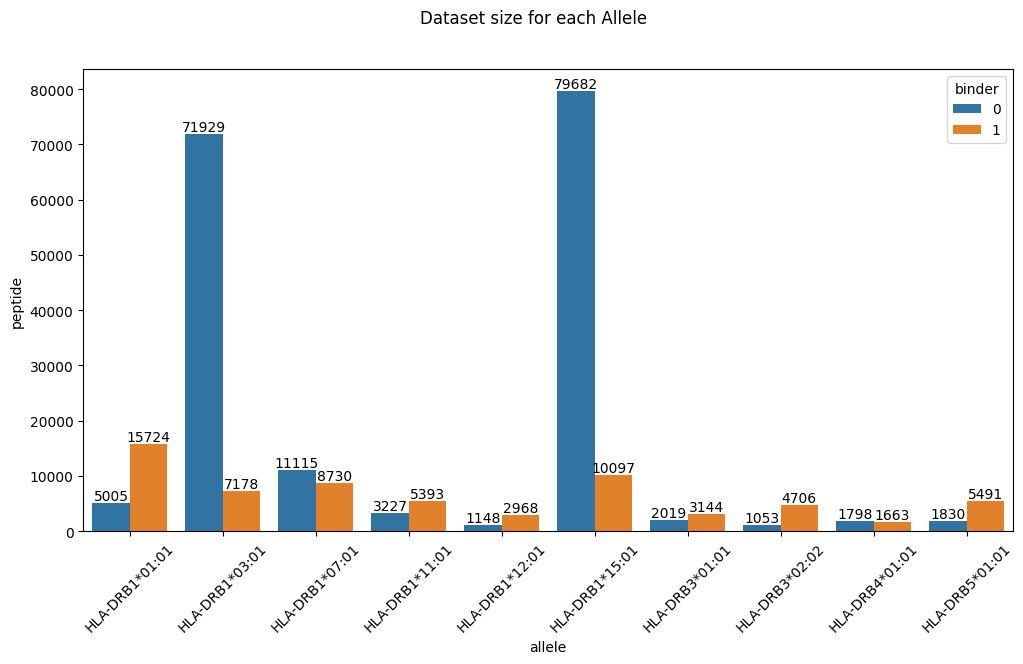

In [17]:
plt.figure(figsize=(12,6))
#target_df = df[df['binder'] == 1]
ax = sns.barplot(data=target_df.groupby(['binder','allele'], as_index=False)['peptide'].count(), x='allele', y='peptide', hue='binder', orient='vertical')
for container in ax.containers:
    ax.bar_label(container)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
for item in ax.get_xticklabels():
    item.set_rotation(45)

ax.figure.suptitle('Dataset size for each Allele')

In [38]:
target_df

,peptide,Epitope_Species,qualitative_measurement,measurement_value,measurement_inequality,allele,MHC Restriction_Class,Assay_Response measured,Assay_Method,protein_id,peptide_start,peptide_end,measurement_type,binder,length
65,MEVGWYRSPFSRVVHLYRNGK,Mus musculus,Positive-High,1600.0,=,HLA-DRB1*15:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/Q61885,63.0,83.0,quantitative,0,21
66,MEVGWYRPPFSRVVHLYRNGK,Homo sapiens,Positive-Low,13500.0,=,HLA-DRB1*15:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/Q16653,64.0,84.0,quantitative,0,21
69,PHHTALRQAILCWGELMTLA,Hepatitis B virus,Positive-Intermediate,676.0,=,HLA-DRB1*07:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/P0C767,50.0,69.0,quantitative,0,20
72,PHHTALRQAILCWGELMTLA,Hepatitis B virus,Positive-Intermediate,263.0,=,HLA-DRB1*12:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/P0C767,50.0,69.0,quantitative,1,20
74,PHHTALRQAILCWGELMTLA,Hepatitis B virus,Positive-High,9.0,=,HLA-DRB1*15:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/P0C767,50.0,69.0,quantitative,1,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2749113,LLTRYLRIHPQSWVHQIALR,Homo sapiens,Positive,500.0,<,HLA-DRB1*11:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2320.0,2339.0,qualitative,1,20
2749114,LLTRYLRIHPQSWVHQIALR,Homo sapiens,Positive,500.0,<,HLA-DRB1*15:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2320.0,2339.0,qualitative,1,20
2749116,HPQSWVHQIALRMEVLGCEA,Homo sapiens,Positive,500.0,<,HLA-DRB1*03:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2328.0,2347.0,qualitative,1,20
2749118,HPQSWVHQIALRMEVLGCEA,Homo sapiens,Positive,500.0,<,HLA-DRB1*07:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2328.0,2347.0,qualitative,1,20


In [39]:
target_df[['allele', 'MHC Restriction_Class']].drop_duplicates()

,allele,MHC Restriction_Class
65,HLA-DRB1*15:01,II
69,HLA-DRB1*07:01,II
72,HLA-DRB1*12:01,II
75,HLA-DRB5*01:01,II
97,HLA-DRB1*03:01,II
101,HLA-DRB1*11:01,II
104,HLA-DRB4*01:01,II
124,HLA-DRB3*01:01,II
140323,HLA-DRB1*10:01,II
165351,HLA-DRB3*02:02,II


## HLA-DRB1*01:01

In [ ]:
df.loc[df['allele'] == 'HLA-DRB1*01:01']
pep_HLA_DRB1_01_01_b = df_HLA_DRB1_01_01[df_HLA_DRB1_01_01['binder']==1]['peptide']
pep_HLA_DRB1_01_01_b

In [19]:
per_allele_df['HLA-DRB1*01:01'][(per_allele_df['HLA-DRB1*01:01'].binder == 1)&
                                (per_allele_df['HLA-DRB1*01:01'].length >= 9)&
                                (per_allele_df['HLA-DRB1*01:01'].length <= 18)].peptide

67         PHHTALRQAILCWGELMTLA
76              AGFFLLTRILTIPQS
86              LVPFVQWFVGLSPTV
106             RHYLHTLWKAGILYK
126             LQSLTNLLSSNLSWL
                   ...         
2749091    PPIIARYIRLHPTHYSIRST
2749097    KARLHLQGRSNAWRPQVNNP
2749109    LLTRYLRIHPQSWVHQIALR
2749115    HPQSWVHQIALRMEVLGCEA
2749495           PKYVKQNTLKLAR
Name: peptide, Length: 15666, dtype: object

In [16]:
pep_HLA_DRB1_01_01_b = pep_HLA_DRB1_01_01_b.loc[pep_HLA_DRB1_01_01_b.length >= 9].copy()
pep_HLA_DRB1_01_01_b = pep_HLA_DRB1_01_01_b.loc[pep_HLA_DRB1_01_01_b.length <= 18].copy()

,peptide,Epitope_Species,qualitative_measurement,measurement_value,measurement_inequality,allele,MHC Restriction_Class,Assay_Response measured,Assay_Method,protein_id,peptide_start,peptide_end,measurement_type,binder,length
64099,FQLYSDLAH,Yersinia pestis,Positive-High,25.9,=,HLA-B*15:02,I,dissociation constant KD (~EC50),purified MHC/direct/fluorescence,http://www.uniprot.org/uniprot/Q0WG84,265.0,273.0,quantitative,1,9
67948,YLGTPNNTY,Escherichia coli,Positive-High,9.4,=,HLA-B*15:02,I,dissociation constant KD (~EC50),purified MHC/direct/fluorescence,http://www.uniprot.org/uniprot/P16917,957.0,965.0,quantitative,1,9
67949,WQLGTRWRY,Escherichia coli,Positive-High,29.6,=,HLA-B*15:02,I,dissociation constant KD (~EC50),purified MHC/direct/fluorescence,http://www.uniprot.org/uniprot/P23842,106.0,114.0,quantitative,1,9
69888,SQHNYRPGY,Dengue virus,Positive-Intermediate,282.0,=,HLA-B*15:02,I,dissociation constant KD (~EC50),purified MHC/direct/fluorescence,http://www.uniprot.org/uniprot/P17763,1027.0,1035.0,quantitative,1,9
70038,QLQANRRAY,Orthohantavirus hantanense,Positive-High,15.6,=,HLA-B*15:02,I,dissociation constant KD (~EC50),purified MHC/direct/fluorescence,http://www.uniprot.org/uniprot/P23456,1697.0,1705.0,quantitative,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586931,VLLPKKTESHHK,Homo sapiens,Positive,500.0,<,HLA-B*15:02,I,ligand presentation,cellular MHC/mass spectrometry,http://www.uniprot.org/uniprot/Q93077,115.0,126.0,qualitative,1,12
2586932,VNTLIRPDGEK,Homo sapiens,Positive,500.0,<,HLA-B*15:02,I,ligand presentation,cellular MHC/mass spectrometry,http://www.uniprot.org/uniprot/P62750,124.0,134.0,qualitative,1,11
2586933,VVSEDFLQDVSASTK,Homo sapiens,Positive,500.0,<,HLA-B*15:02,I,ligand presentation,cellular MHC/mass spectrometry,http://www.uniprot.org/uniprot/P09874,453.0,467.0,qualitative,1,15
2586936,YGRPPDSHHSR,Homo sapiens,Positive,500.0,<,HLA-B*15:02,I,ligand presentation,cellular MHC/mass spectrometry,http://www.uniprot.org/uniprot/Q01130,92.0,102.0,qualitative,1,11


In [13]:
df_HLA_DRB1_01_01 = df.loc[df['allele'] == 'HLA-DRB1*01:01']
df_HLA_DRB1_01_01

,peptide,Epitope_Species,qualitative_measurement,measurement_value,measurement_inequality,allele,MHC Restriction_Class,Assay_Response measured,Assay_Method,protein_id,peptide_start,peptide_end,measurement_type,binder,length
67,PHHTALRQAILCWGELMTLA,Hepatitis B virus,Positive-High,70.0,=,HLA-DRB1*01:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/P0C767,50.0,69.0,quantitative,1,20
76,AGFFLLTRILTIPQS,Hepatitis B virus,Positive-High,1.0,=,HLA-DRB1*01:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q76R62,180.0,194.0,quantitative,1,15
86,LVPFVQWFVGLSPTV,Hepatitis B virus,Positive-Intermediate,385.0,=,HLA-DRB1*01:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q76R62,339.0,353.0,quantitative,1,15
96,VGPLTVNEKRRLKLI,Hepatitis B virus,Positive-Low,8415.0,=,HLA-DRB1*01:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q69028,96.0,110.0,quantitative,0,15
106,RHYLHTLWKAGILYK,Hepatitis B virus,Positive-High,17.0,=,HLA-DRB1*01:01,II,half maximal inhibitory concentration (IC50),purified MHC/competitive/radioactivity,http://www.uniprot.org/uniprot/Q69028,145.0,159.0,quantitative,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2749097,KARLHLQGRSNAWRPQVNNP,Homo sapiens,Positive,500.0,<,HLA-DRB1*01:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2226.0,2245.0,qualitative,1,20
2749103,TQGVKSLLTSMYVKEFLISS,Homo sapiens,Negative,5000.0,>,HLA-DRB1*01:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2264.0,2283.0,qualitative,0,20
2749109,LLTRYLRIHPQSWVHQIALR,Homo sapiens,Positive,500.0,<,HLA-DRB1*01:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2320.0,2339.0,qualitative,1,20
2749115,HPQSWVHQIALRMEVLGCEA,Homo sapiens,Positive,500.0,<,HLA-DRB1*01:01,II,qualitative binding,purified MHC/competitive/fluorescence,http://www.uniprot.org/uniprot/P00451,2328.0,2347.0,qualitative,1,20


peptide binders

In [14]:
pep_HLA_DRB1_01_01_b = df_HLA_DRB1_01_01[df_HLA_DRB1_01_01['binder']==1]['peptide']
pep_HLA_DRB1_01_01_b

67         PHHTALRQAILCWGELMTLA
76              AGFFLLTRILTIPQS
86              LVPFVQWFVGLSPTV
106             RHYLHTLWKAGILYK
126             LQSLTNLLSSNLSWL
                   ...         
2749091    PPIIARYIRLHPTHYSIRST
2749097    KARLHLQGRSNAWRPQVNNP
2749109    LLTRYLRIHPQSWVHQIALR
2749115    HPQSWVHQIALRMEVLGCEA
2749495           PKYVKQNTLKLAR
Name: peptide, Length: 15724, dtype: object

peptide non-binders 

In [16]:
pep_HLA_DRB1_01_01_nb = df_HLA_DRB1_01_01[df_HLA_DRB1_01_01['binder']==0]['peptide']
pep_HLA_DRB1_01_01_nb

96              VGPLTVNEKRRLKLI
118             ESRLVVDFSQFSRGN
185             LCQVFADATPTGWGL
226               DPIELNATLSAVA
240            VAFRAGLVMEAGSKVT
                   ...         
2749057    GHTFLVRNHRQASLEISPIT
2749065    RHYFIAAVERLWDYGMSSSP
2749073    KKEEYKMALYNLYPGVFETV
2749077    KLARLHYSGSINAWSTKEPF
2749103    TQGVKSLLTSMYVKEFLISS
Name: peptide, Length: 5005, dtype: object

Save data

In [20]:
pep_HLA_DRB1_01_01_b.to_csv('C:/Projects/grandmaster/notebooks/pep_HLA_DRB1_01_01_b.csv', index=False)
pep_HLA_DRB1_01_01_nb.to_csv('C:/Projects/grandmaster/notebooks/pep_HLA_DRB1_01_01_nb.csv', index=False)
